In [1]:
import numpy as np
import matplotlib.pyplot as plt

from doepy import ProblemInstance
from doepy.models import Model, NonLinearModel, CandidateWrapper
from doepy.optimize import slsqp
from doepy.constraints import ControlDeltaConstraint, MeanStateConstraint
from doepy.design_criteria import JR
from doepy.noise_divergence import KL_P0Pw, KL_PwP0
from doepy.case_studies.discrete_time import nonlinear1

In [2]:
"""
Initialise models
"""
datagen, Ms = nonlinear1.get()

D = Ms[0].num_inputs
N = Ms[0].num_steps 

datagen = Model(CandidateWrapper(**datagen.get_candidate_dict()))
models  = [ NonLinearModel(CandidateWrapper(**M.get_candidate_dict())) for M in Ms ]
num_M   = len(models)

"""
Objective function and constraints
"""
divcriterion = JR()
uconst = ControlDeltaConstraint(Ms[0].u_delta)
yconst = MeanStateConstraint(Ms[0].y_bounds)
bounds = Ms[0].u_bounds

# Create problem instance
PI = ProblemInstance(models, N, divcriterion, bounds, uconst, yconst)

"""
Optimise control inputs
"""
U0  = PI.sample_U(check_constraints=False)
res = slsqp(PI, U0)
U   = res['x']

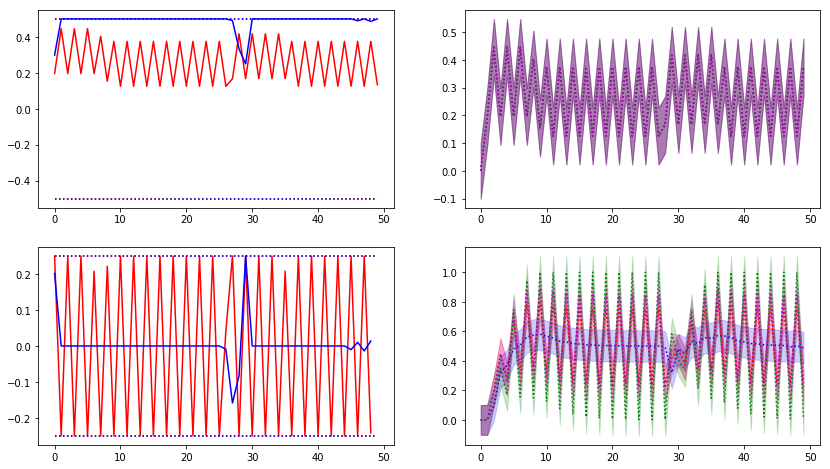

In [8]:
"""
Multi-step prediction
"""
fig, axs = plt.subplots(2,2,figsize=(14,8))

T = np.arange(N)

for i,ub in enumerate(Ms[0].u_bounds):
    c = ['r','b'][i]
    axs[0][0].plot(T, U[:,i], c=c)
    axs[0][0].plot(T[[0,-1]], [ub[0],ub[0]], c=c, linestyle=':')
    axs[0][0].plot(T[[0,-1]], [ub[1],ub[1]], c=c, linestyle=':')
    axs[1][0].plot(T[:-1], U[1:,i]-U[:-1,i], c=c)
    ud = Ms[0].u_delta[i]
    axs[1][0].plot(T[[0,-1]], [-ud,-ud], c=c, linestyle=':')
    axs[1][0].plot(T[[0,-1]], [ud,ud], c=c, linestyle=':')

#def plot (p, n, t, m, s, c, l=':'):
def plot (p, m, s, c, l=':'):
    #p.plot(n, t, c=c)
    p.plot(T, m, c=c, linestyle=l)
    p.fill_between(T, m+2*s, m-2*s, color=c, alpha=0.2)

Yp, Ep = np.zeros((num_M,N,2)), np.zeros((num_M,N,2,2))
cols = ['r','b','g','m']
for i,model in enumerate(models):
    Xp, Sp = model.predict_x_dist( model.x0, model.S_x0, U )
    Yp[i], Ep[i] = model.predict_y_dist( Xp[:-1], Sp[:-1] )

    plot(axs[0][1], Yp[i,:,0], np.sqrt(Ep[i,:,0,0]), cols[i])
    plot(axs[1][1], Yp[i,:,1], np.sqrt(Ep[i,:,1,1]), cols[i])
plt.show()

In [5]:
"""
Experimental data
"""
_, Y = datagen.sample(datagen.x0, U, initial_uncertainty=True)

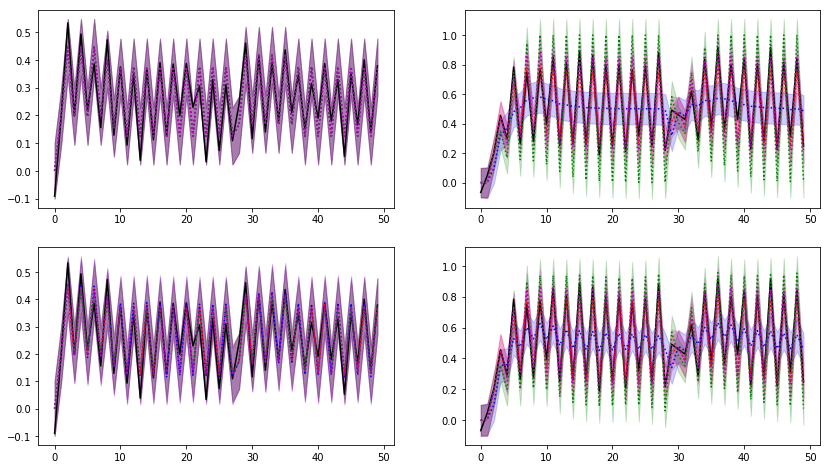

In [11]:
"""
Filtered
"""
fig, axs = plt.subplots(2,2,figsize=(14,8))
for j in range(2):
    axs[j][0].plot(T, Y[:,0], c='k')
    axs[j][1].plot(T, Y[:,1], c='k')

def plot (p, m, s, c, l=':'):
    p.plot(T, m, c=c, linestyle=l)
    p.fill_between(T, m+2*s, m-2*s, color=c, alpha=0.2)

Ys, Es = np.zeros((num_M,N,2)), np.zeros((num_M,N,2,2))
cols   = ['r','b','g','m']
for i,model in enumerate(models):
    plot(axs[0][0], Yp[i,:,0], np.sqrt(Ep[i,:,0,0]), cols[i])
    plot(axs[0][1], Yp[i,:,1], np.sqrt(Ep[i,:,1,1]), cols[i])
    
    Xk, Sk = model.predict_filter( Y, model.x0, model.S_x0, U )
    Xs, Ss = model.smooth( Xk, Sk, U )
    Ys[i], Es[i] = model.predict_y_dist( Xs, Ss )

    plot(axs[1][0], Ys[i,:,0], np.sqrt(Es[i,:,0,0]), cols[i])
    plot(axs[1][1], Ys[i,:,1], np.sqrt(Es[i,:,1,1]), cols[i])
plt.show()

In [7]:
"""
Noise divergences
"""
D1 = KL_P0Pw(Y, Ys, Es)
D2 = KL_PwP0(Y, Ys, Es)

print( "    ".join(["{:.3f}"]*num_M).format(*D1) )
print( "    ".join(["{:.3f}"]*num_M).format(*D2) )

0.097    0.952    0.473    0.021
0.092    6.307    1.449    0.018
